In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('SLDC_Data/2017/10/01-10-2017.csv')
data['date'] = '01-10-2017'
data = extract_dt(data)

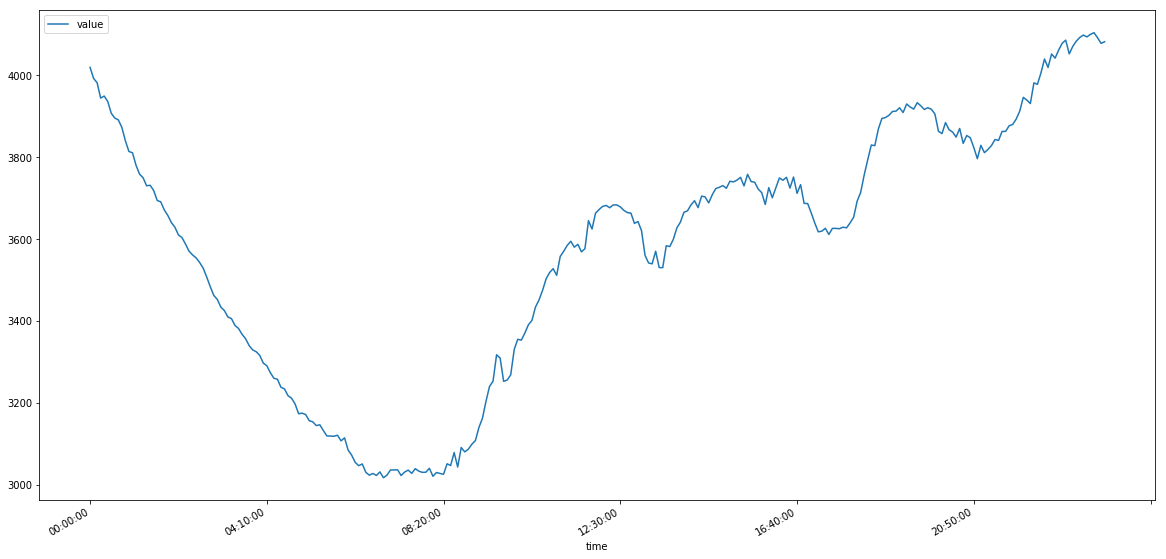

In [3]:
data.plot(x='time', y='value', subplots=True, figsize=(20, 10)); plt.legend(loc='best');

In [4]:
data.head()

,time,value,date,datetime,hour
0,00:00:00,4019.64,01-10-2017,00:00:00,0
1,00:05:00,3992.69,01-10-2017,00:05:00,0
2,00:10:00,3982.11,01-10-2017,00:10:00,0
3,00:15:00,3944.66,01-10-2017,00:15:00,0
4,00:20:00,3949.66,01-10-2017,00:20:00,0


In [5]:
load_data = data['value'].values # (length)
load_data = load_data.reshape(-1, 1) # (length, 1)

In [6]:
# normalize the data, between 0 - 1
# load_data = (load_data - np.min(load_data)) / (np.max(load_data) - np.min(load_data))
scaler = MinMaxScaler(feature_range=(0, 1))
load_data = scaler.fit_transform(load_data)

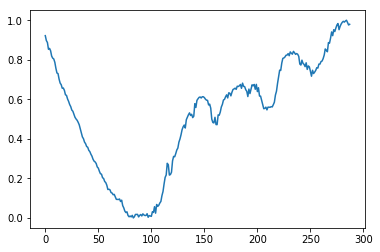

In [7]:
plt.plot(load_data)

In [8]:
# split into train and test sets
train_size = int(len(load_data) * 0.67)
test_size = len(load_data) - train_size
train, test = load_data[0:train_size, :], load_data[train_size:len(load_data), :]
print(len(train), len(test))

192 96


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [23]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [24]:
trainX[:5], trainY[:5]

(array([[ 0.92200311,  0.89720349,  0.88746768],
        [ 0.89720349,  0.88746768,  0.85300586],
        [ 0.88746768,  0.85300586,  0.85760691],
        [ 0.85300586,  0.85760691,  0.84557978],
        [ 0.85760691,  0.84557978,  0.8187833 ]]),
 array([ 0.85300586,  0.85760691,  0.84557978,  0.8187833 ,  0.8081917 ]))

In [25]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
trainX.shape, testX.shape

((188, 1, 3), (92, 1, 3))

In [27]:
trainX[:5], '\n', testX[:5]

(array([[[ 0.92200311,  0.89720349,  0.88746768]],
 
        [[ 0.89720349,  0.88746768,  0.85300586]],
 
        [[ 0.88746768,  0.85300586,  0.85760691]],
 
        [[ 0.85300586,  0.85760691,  0.84557978]],
 
        [[ 0.85760691,  0.84557978,  0.8187833 ]]]),
 '\n',
 array([[[ 0.65174702,  0.62914669,  0.65133292]],
 
        [[ 0.62914669,  0.65133292,  0.67360197]],
 
        [[ 0.65133292,  0.67360197,  0.6684304 ]],
 
        [[ 0.67360197,  0.6684304 ,  0.6750283 ]],
 
        [[ 0.6684304 ,  0.6750283 ,  0.65081761]]]))

In [28]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 1s - loss: 0.0910
Epoch 2/20
 - 1s - loss: 0.0207
Epoch 3/20
 - 1s - loss: 0.0100
Epoch 4/20
 - 1s - loss: 0.0043
Epoch 5/20
 - 1s - loss: 0.0017
Epoch 6/20
 - 1s - loss: 9.7110e-04
Epoch 7/20
 - 1s - loss: 8.2365e-04
Epoch 8/20
 - 1s - loss: 7.9689e-04
Epoch 9/20
 - 1s - loss: 7.8994e-04
Epoch 10/20
 - 1s - loss: 7.7757e-04
Epoch 11/20
 - 1s - loss: 7.7962e-04
Epoch 12/20
 - 1s - loss: 7.6259e-04
Epoch 13/20
 - 1s - loss: 7.6520e-04
Epoch 14/20
 - 1s - loss: 7.6211e-04
Epoch 15/20
 - 1s - loss: 7.6152e-04
Epoch 16/20
 - 1s - loss: 7.1931e-04
Epoch 17/20
 - 1s - loss: 7.2121e-04
Epoch 18/20
 - 1s - loss: 7.3448e-04
Epoch 19/20
 - 1s - loss: 7.0066e-04
Epoch 20/20
 - 1s - loss: 7.1897e-04


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28.10 RMSE
Test Score: 45.47 RMSE


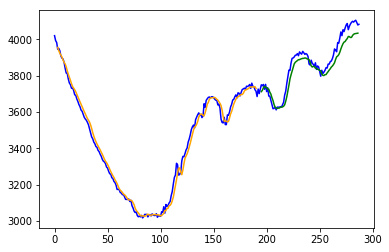

In [35]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(load_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(load_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(load_data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(load_data), c='blue')
plt.plot(trainPredictPlot, c='orange')
plt.plot(testPredictPlot, c='green')
plt.show()

## Testing

In [32]:
model.save_weights('models/lstm-v1.h5')